In [2]:
# Build model using transfer learning MobileNet

In [3]:
# Requirement Lib Import
import os
import random
import gdown
import tensorflow as tf
from tensorflow import keras

# Set default desired model input shape size
INPUT_SIZE = (224, 224) # Mobilenet support input size pre-train weights: [96, 128, 160, 192, 224]
CUSTOM_MODEL_NAME = 'custom-mobnet-pretrained'

WORKING_PATHS = {
    'BASE': os.path.join('workspace'),
    'DATASET': os.path.join('workspace', 'dataset'),
    'TRAIN_DATASET': os.path.join('workspace', 'dataset', 'train'),
    'TEST_DATASET': os.path.join('workspace', 'dataset', 'test'),
    'OUTPUT': os.path.join('workspace', 'output'), 
    'EXPORT': os.path.join('workspace', 'output', CUSTOM_MODEL_NAME, 'export'), 
    'TFLITE':os.path.join('workspace', 'output', CUSTOM_MODEL_NAME, 'tfliteexport'), 
 }

In [4]:
# Create working dirs
for path in WORKING_PATHS.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [5]:
# Download dataset
ARCHIVED_NAME = 'hand-sign-bisindo-divided.zip'
ARCHIVED_ID = '1Ijw3vqMtbaCZxop11UxjnDBOjcXY_voK'
GLINK = 'https://drive.google.com/uc?id={}'.format(ARCHIVED_ID)

if not os.path.exists(os.path.join(WORKING_PATHS['DATASET'], ARCHIVED_NAME)):
    if os.name == 'posix':
        !gdown {GLINK}
        !mv {ARCHIVED_NAME} {WORKING_PATHS['DATASET']}
        !cd {WORKING_PATHS['DATASET']} && unzip -a {ARCHIVED_NAME}
    if os.name == 'nt':
        gdown.download(GLINK, ARCHIVED_NAME, quiet = False)
        !move {ARCHIVED_NAME} {WORKING_PATHS['DATASET']}
        !cd {WORKING_PATHS['DATASET']} && tar -zxvf {ARCHIVED_NAME}

Downloading...
From: https://drive.google.com/uc?id=1Ijw3vqMtbaCZxop11UxjnDBOjcXY_voK
To: d:\Capstone\Repo\hand-sign-bisindo-divided.zip
28.2MB [02:36, 180kB/s] 
        1 file(s) moved.
x train/
x train/A/
x train/A/20210513_203145(0).jpg
x train/A/20210513_203145.jpg
x train/A/20210513_203147(0).jpg
x train/A/20210513_203148.jpg
x train/A/20210513_203149.jpg
x train/A/20210513_203150(0).jpg
x train/A/20210513_203150.jpg
x train/A/20210513_203153.jpg
x train/A/20210513_203154(0).jpg
x train/A/20210513_203154.jpg
x train/A/20210513_203156(0).jpg
x train/A/20210513_203157(0).jpg
x train/A/20210513_203157.jpg
x train/A/20210513_203158(0).jpg
x train/A/20210513_203158.jpg
x train/A/20210513_203203(0).jpg
x train/A/20210513_203203.jpg
x train/A/20210513_203204(0).jpg
x train/A/20210513_203204(1).jpg
x train/A/20210513_203204.jpg
x train/A/20210513_203205(0).jpg
x train/A/20210513_203205.jpg
x train/A/20210513_203206(0).jpg
x train/A/20210513_203206.jpg
x train/A/20210513_203207(0).jpg
x tr

d:\Capstone\Repo\env_playground\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
No handles with labels found to put in legend.
d:\Capstone\Repo\env_playground\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
No handles with labels found to put in legend.


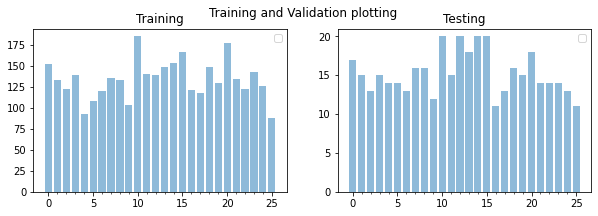

In [6]:
# Check total dataset each labels
import numpy as np
import matplotlib.pyplot as plt

static_labels = os.listdir(WORKING_PATHS['TRAIN_DATASET'])
TRAIN_IMG_MIN = 9999
train_data_num = {}
test_data_num = {}

for label in static_labels:
    train_data_num[label] = len(os.listdir(os.path.join(WORKING_PATHS['TRAIN_DATASET'], label))) 
    test_data_num[label] = len(os.listdir(os.path.join(WORKING_PATHS['TEST_DATASET'], label)))  
    if train_data_num[label] < TRAIN_IMG_MIN:
        TRAIN_IMG_MIN = train_data_num[label]

y_pos = np.arange(len(static_labels))
train_values = train_data_num.values()
test_values = test_data_num.values()

fig, axs = plt.subplots(1, 2, figsize = (10, 3))
fig.suptitle('Training and Validation plotting')
axs[0].bar(y_pos, train_values, align = 'center', alpha = 0.5)
axs[0].set_xticks(y_pos, static_labels)
axs[0].set_title('Training')
axs[0].legend()
axs[1].bar(y_pos, test_values, align = 'center', alpha = 0.5)
axs[1].set_xticks(y_pos, static_labels)
axs[1].set_title('Testing')
axs[1].legend()

plt.show()

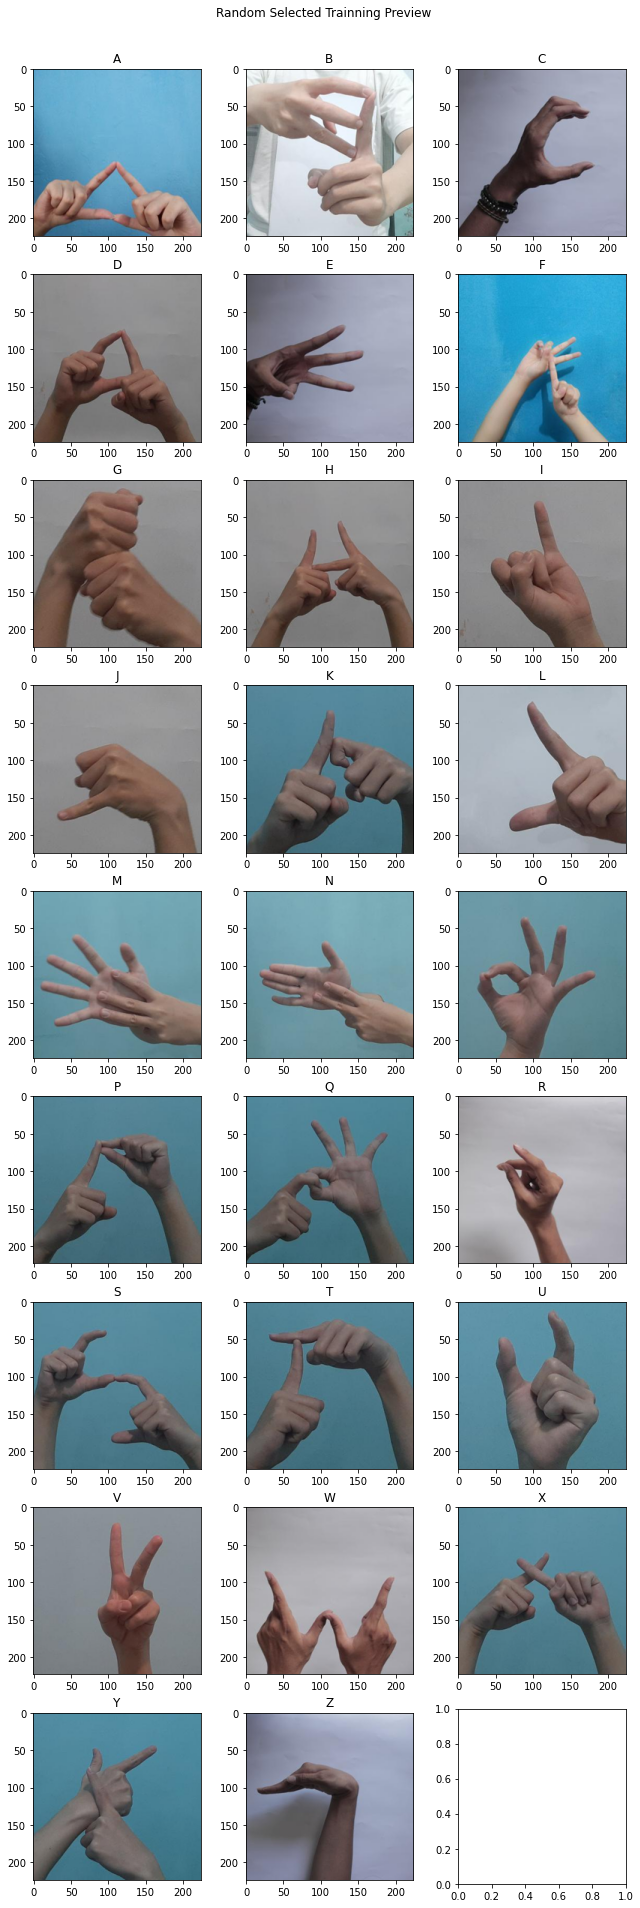

In [7]:
# Requirement Lib Import
import math
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Random seed
seed = random.randint(0, TRAIN_IMG_MIN)

# plot matrix size
cols = 3
rows = math.ceil(len(static_labels) / 3)

# Show image plot
fig_size = 3
fig, axs = plt.subplots(rows, cols, figsize = ((fig_size * cols), (fig_size * rows)))
fig.suptitle('Random Selected Trainning Preview')
fig.tight_layout()
fig.subplots_adjust(top = 0.95)
axs = axs.ravel()

# Image training random selector
img_dict = {}
for idx, label in enumerate(static_labels):
    img_path = os.path.join(WORKING_PATHS['TRAIN_DATASET'], label)
    img_rand = os.listdir(img_path)[seed]
    img_selc = image.load_img(os.path.join(img_path, img_rand))

    axs[idx].imshow(img_selc.resize(INPUT_SIZE))
    axs[idx].set_title(label)

In [8]:
# Dataset pre-processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
validation_datagen = ImageDataGenerator(rescale = 1 / 255)

train_generator = train_datagen.flow_from_directory(
    WORKING_PATHS['TRAIN_DATASET'],
    target_size = INPUT_SIZE,
    class_mode = 'categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    WORKING_PATHS['TEST_DATASET'],
    target_size = INPUT_SIZE,
    class_mode = 'categorical'
)

Found 3481 images belonging to 26 classes.
Found 397 images belonging to 26 classes.


In [9]:
# defined classes based on foldering structure, sort by alphabetical
LABELS = list(train_generator.class_indices.keys())
NUM_CLASSES = len(LABELS) # Set classes num
print(NUM_CLASSES)

26


In [13]:
class EarlyStoppingAtGivenAccuracy(keras.callbacks.Callback):
    """
        Stop training when the accuracy at given threshold
    """
    def __init__(self, threshold = 0.9):
        super(EarlyStoppingAtGivenAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        acc = logs.get('accuracy')
        if acc is not None:
            if acc >= self.threshold:
                print('Epoch {}: Reached baseline, stop training'.format(epoch))
                self.model.stop_training = True

In [14]:
# from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV2

pre_trained_model = MobileNetV2(
    weights = 'imagenet', 
    input_shape = (INPUT_SIZE[0], INPUT_SIZE[1], 3), 
    include_top = False, 
)

pre_trained_model.trainable = False

In [15]:
# Fine Tuning
pre_trained_model.trainable = True

for layer in pre_trained_model.layers[:100]:
    layer.trainable = False

In [18]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
# More info about Adam optimzer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation = 'relu')(x)
# Add a dropout rate of 0.1
x = layers.Dropout(0.1)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(NUM_CLASSES, activation = 'softmax')(x)  

# Re-Create model
model = Model(inputs = pre_trained_model.input, outputs = x)

model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')
])

# Compile Model
model.compile(
    optimizer = Adam(learning_rate = 0.0001), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

# Start Training!
callback = EarlyStoppingAtGivenAccuracy(0.97)
history = model.fit(
    train_generator, 
    validation_data = validation_generator, 
    epochs = 30, 
    validation_steps = 5,
    verbose = 1,
    # callbacks = [callback]
)

Epoch 1/30
109/109 [==============================] - 47s 411ms/step - loss: 0.4628 - accuracy: 0.8750 - val_loss: 1.0141 - val_accuracy: 0.7812
Epoch 2/30
109/109 [==============================] - 46s 423ms/step - loss: 0.1082 - accuracy: 0.9661 - val_loss: 1.0806 - val_accuracy: 0.8500
Epoch 3/30
109/109 [==============================] - 48s 438ms/step - loss: 0.0683 - accuracy: 0.9790 - val_loss: 0.7179 - val_accuracy: 0.8813
Epoch 4/30
109/109 [==============================] - 48s 442ms/step - loss: 0.0985 - accuracy: 0.9707 - val_loss: 1.1405 - val_accuracy: 0.8813
Epoch 5/30
109/109 [==============================] - 50s 454ms/step - loss: 0.0791 - accuracy: 0.9810 - val_loss: 0.9163 - val_accuracy: 0.8938
Epoch 6/30
109/109 [==============================] - 51s 465ms/step - loss: 0.0485 - accuracy: 0.9842 - val_loss: 0.3035 - val_accuracy: 0.9563
Epoch 7/30
109/109 [==============================] - 51s 469ms/step - loss: 0.0245 - accuracy: 0.9931 - val_loss: 0.1239 - val_ac

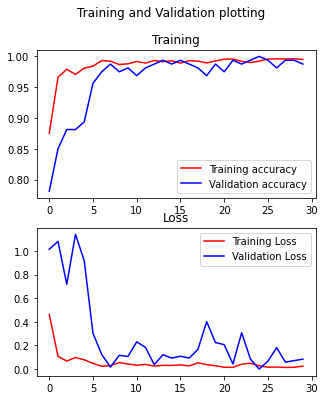

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, axs = plt.subplots(2, 1, figsize = (5, 6))
fig.suptitle('Training and Validation plotting')
axs[0].plot(epochs, acc, 'r', label = 'Training accuracy')
axs[0].plot(epochs, val_acc, 'b', label = 'Validation accuracy')
axs[0].set_title('Training')
axs[0].legend()
axs[1].plot(epochs, loss, 'r', label = 'Training Loss')
axs[1].plot(epochs, val_loss, 'b', label = 'Validation Loss')
axs[1].set_title('Loss')
axs[1].legend()
plt.show()

In [20]:
from tensorflow.keras.optimizers import Adam
# More info about Adam optimzer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

# Compile Model
model.compile(
    optimizer = Adam(learning_rate = 0.000001), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

# Start Training!
callback = EarlyStoppingAtGivenAccuracy(0.9999)
history2 = model.fit(
    train_generator, 
    validation_data = validation_generator, 
    initial_epoch = 30,
    epochs = 60, 
    validation_steps = 5,
    verbose = 1,
    callbacks = [callback]
)

Epoch 31/60
109/109 [==============================] - 53s 455ms/step - loss: 0.0125 - accuracy: 0.9968 - val_loss: 0.0789 - val_accuracy: 0.9937
Epoch 32/60
109/109 [==============================] - 51s 469ms/step - loss: 0.0161 - accuracy: 0.9974 - val_loss: 0.1767 - val_accuracy: 0.9812
Epoch 33/60
109/109 [==============================] - 54s 497ms/step - loss: 0.0113 - accuracy: 0.9966 - val_loss: 0.0357 - val_accuracy: 0.9937
Epoch 34/60
109/109 [==============================] - 58s 531ms/step - loss: 0.0075 - accuracy: 0.9977 - val_loss: 0.1101 - val_accuracy: 0.9875
Epoch 35/60
109/109 [==============================] - 58s 533ms/step - loss: 0.0175 - accuracy: 0.9963 - val_loss: 1.6483e-05 - val_accuracy: 1.0000
Epoch 36/60
109/109 [==============================] - 57s 525ms/step - loss: 0.0033 - accuracy: 0.9989 - val_loss: 0.1087 - val_accuracy: 0.9875
Epoch 37/60
109/109 [==============================] - 55s 503ms/step - loss: 0.0088 - accuracy: 0.9971 - val_loss: 7.01

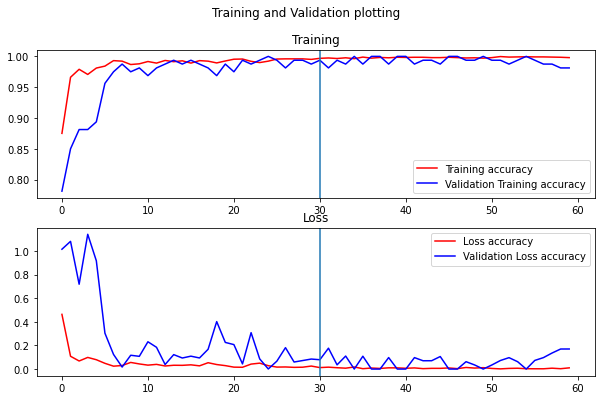

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs = range(len(acc) + len(acc2))

fig, axs = plt.subplots(2, 1, figsize = (10, 6))
fig.suptitle('Training and Validation plotting')
axs[0].plot(epochs, acc + acc2, 'r', label = 'Training accuracy')
axs[0].plot(epochs, val_acc + val_acc2, 'b', label = 'Validation Training accuracy')
axs[0].set_title('Training')
axs[0].legend()
axs[0].axvline(x = len(acc))
axs[1].plot(epochs, loss + loss2, 'r', label = 'Loss accuracy')
axs[1].plot(epochs, val_loss + val_loss2, 'b', label = 'Validation Loss accuracy')
axs[1].set_title('Loss')
axs[1].legend()
axs[1].axvline(x = len(acc))
plt.show()

In [22]:
def selectRandomImage(labels = None):
    if labels == None:
        seed = random.randint(1, NUM_CLASSES)
        label_seed = LABELS[seed - 1]
    else:
        seed = random.randint(1, len(labels))
        label_seed = labels[seed - 1]
    
    path = os.path.join(WORKING_PATHS['TRAIN_DATASET'], label_seed)
    test_dir = os.listdir(path)
    test_dir_num = len(test_dir)
    file_name = os.listdir(path)[random.randint(0, test_dir_num - 1)]
    return (os.path.join(path, file_name), file_name, label_seed)

In [23]:
def createResultPlot(prediction_list, prediction_label, actual_label, file_name):
    # Result Plot
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))
    fig.suptitle('Image {} predict as: {}'.format(file_name, prediction_label))
    fig.subplots_adjust(top = 2)
    fig.tight_layout()
    axs = axs.ravel()

    # See other color refrences: https://xkcd.com/color/rgb/
    if prediction_label == actual_label:
        #If prediction True
        fig.patch.set_facecolor('xkcd:mint green')
    else:
        #If prediction False
        fig.patch.set_facecolor('xkcd:pale pink')

    # Show selected image
    axs[0].set_title(actual_label)
    axs[0].imshow(img)

    # Prediction Probabilities Plot
    axs[1].set_title('Probabilities')
    axs[1].bar(range(0, NUM_CLASSES), prediction_list, align = 'center')
    axs[1].set_xticks(range(0, NUM_CLASSES))
    axs[1].set_xticklabels(LABELS)

    plt.show()

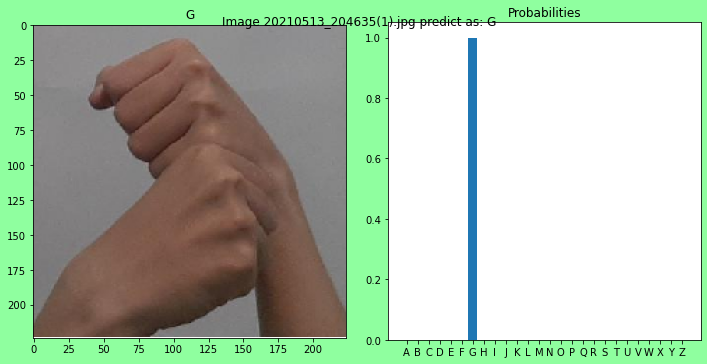

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# predicting images
# file_path, file_name, label = selectRandomImage()
file_path, file_name, label = selectRandomImage(['G'])
img = image.load_img(file_path, target_size = INPUT_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

prediction = model.predict(x, batch_size = 10) # Predict Image
index = int(prediction[0].argmax(axis = -1)) # Get max classes index

# Result Plot
createResultPlot(prediction[0].reshape(NUM_CLASSES), LABELS[index], label, file_name)

In [25]:
# Create confussion matrix to all label in test dir
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix

# Variable storing pred
y_true = [] # Actual 
y_pred = [] # Pediction

for label in LABELS:
    # Get iamges
    path = os.path.join(WORKING_PATHS['TEST_DATASET'], label)
    files = os.listdir(path)
    for idx, file_name in enumerate(files):
        file_loc = os.path.join(path, file_name)
        img = image.load_img(file_loc, target_size = INPUT_SIZE)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis = 0)
        x = preprocess_input(x)

        prediction = model.predict(x, batch_size = 10) # Predict Image
        index = int(prediction[0].argmax(axis = -1)) # Get max classes index
        y_true.append(label)
        y_pred.append(LABELS[index])
        # print('Image with label {} predicted as {}'.format(label, LABELS[index]))

mat = confusion_matrix(y_true, y_pred, labels = LABELS)

# Normalize result
mat_norm = mat / mat.astype(np.float).sum(axis = 1)

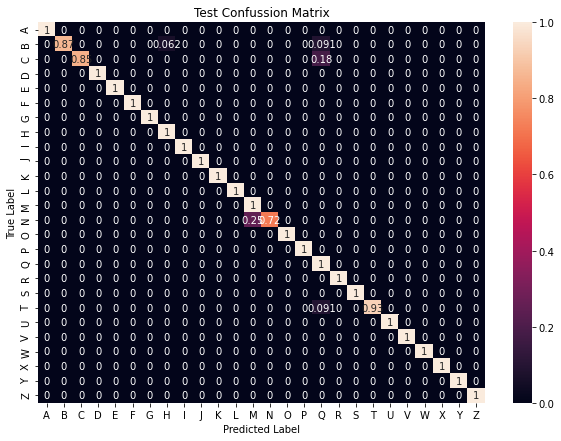

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(mat_norm, index = LABELS, columns = LABELS)

plt.figure(figsize = (10,7))
ax = sn.heatmap(df_cm, annot = True)
ax.set_title("Test Confussion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

plt.show()

In [28]:
# Save model
model.save(os.path.join(os.getcwd(), WORKING_PATHS['EXPORT']))

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(WORKING_PATHS['EXPORT']) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open(os.path.join(WORKING_PATHS['TFLITE'], 'model.tflite'), 'wb') as f:
  f.write(tflite_model)